In [1]:
import pandas as pd
import numpy as np
import datetime
from os.path import join
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

In [2]:
def readcm(name):
    '''Read colormap from file formatted as 0-1 RGB CSV'''
    rgb = []
    fh = open(name, 'r')
    for line in fh.read().splitlines(): rgb.append(list(map(float,line.split())))
    return rgb

In [3]:
%%time
#obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_obs_2016_2019.nc') # all binary observations for 2016 on 80-km grid
#probs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_probs_2016_2019_w_LR.nc') # neighborhood prob files for each NCAR700 forecast on 80-km grid
#matched_obs = xr.open_dataset('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/matched_obs_2016_2019.nc') # binary observations for NCAR700 forecasts on 80-km grid
labels = pd.read_parquet('/glade/scratch/cbecker/WRF_labels_20220923/combined_data/combined_labels_2016_2019_w_LR.parquet') # raw probability file for each storm object (not on 80-km grid)

# only use 2016 forecasts
#probs = probs.where(probs['init_time'] <= np.datetime64('2016-12-31'), drop=True)
labels = labels[labels['Run_Date'] <= np.datetime64('2016-12-31')]
#matched_obs = obs.swap_dims({'time':"valid_time"}).sel(valid_time=probs['valid_time'])

# SS_label field shows cluster label??
categories = { 0: 'QLCS', 1: 'Supercell', 2: 'Disorganized' }
labels['SS_label'] = np.argmax( labels[['SS_QLCS_prob','SS_Supercell_prob','SS_Disorganized_prob']].values , axis=1)
labels['SS_label'] = labels['SS_label'].apply(lambda x: categories[x])

# Add LR_label_prob column
lr_prob_values = labels[['LR_QLCS_prob', 'LR_Supercell_prob', 'LR_Disorganized_prob']].values
lr_prob_argmax = np.argmax(lr_prob_values, axis=1)
labels['LR_label_prob'] = lr_prob_values[range(lr_prob_argmax.size), lr_prob_argmax]

data_path = '/glade/work/cbecker/WRF_all/track_data_hrrr_3km_nc_refl/'

CPU times: user 170 ms, sys: 86.3 ms, total: 257 ms
Wall time: 526 ms


/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  This is separate from the ipykernel package so we can avoid doing imports until


storm 1
storm 2
storm 3
storm 4
storm 5
storm 1
storm 2
storm 3
storm 4
storm 5
storm 1
storm 2
storm 3
storm 4
storm 5


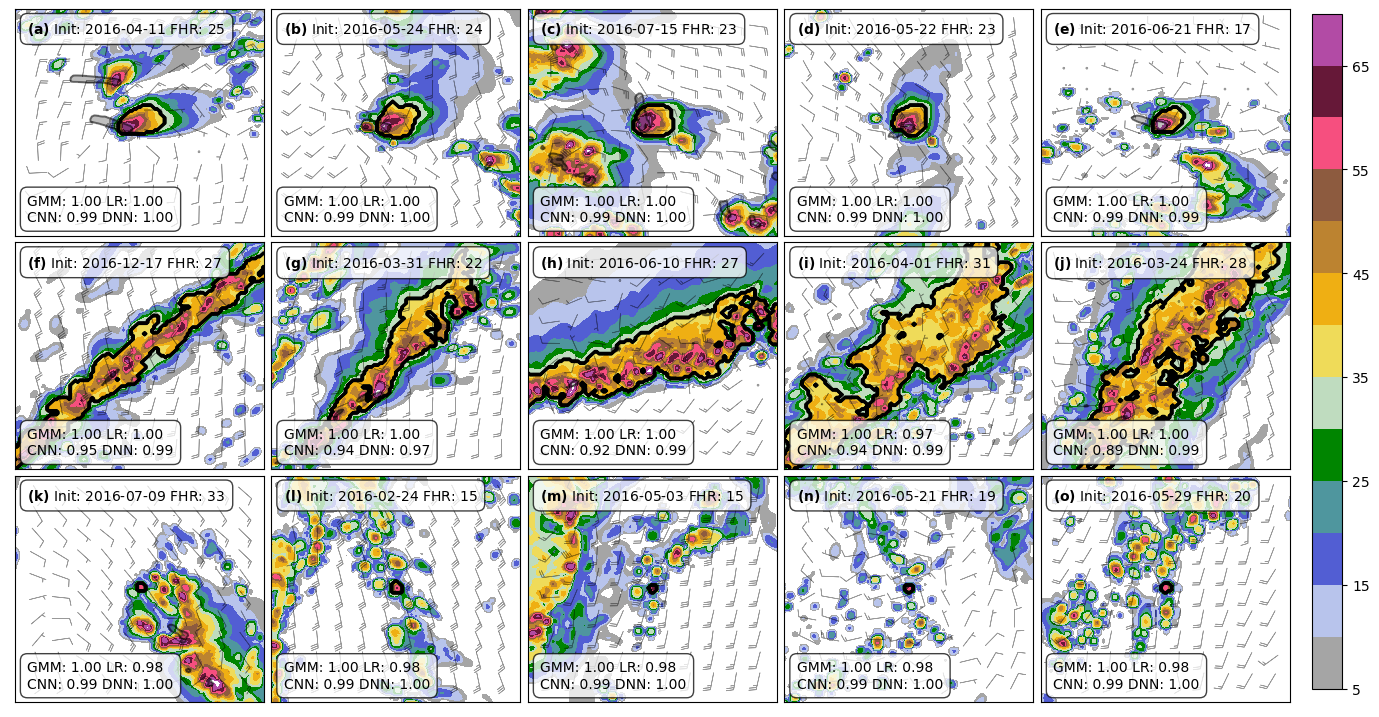

In [5]:
num_storms = 5
fig, axes = plt.subplots(3, num_storms, figsize=(15,9), constrained_layout=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

import string
panels = list(string.ascii_lowercase)

ms_mph = 2.237
patch_radius = 60
rgb_colors = readcm('/glade/u/home/sobash/NSC_scripts/cmap_rad.rgb')[1:14]
levels = [5,10,15,20,25,30,35,40,45,50,55,60,65,70]
cmap = colors.ListedColormap(rgb_colors)
norm = colors.BoundaryNorm(levels, cmap.N)
    
inits_used = []
for i,mode in enumerate(['Supercell', 'QLCS', 'Disorganized']):
    # rank storms by variance between 4 predictions
    probs = labels[[f'SS_{mode}_prob', f'LR_{mode}_prob', f'CNN_1_{mode}_prob', f'DNN_1_{mode}_prob']].values
    
    labels[f'prob_var_{mode}'] = probs.mean(axis=1)
    #labels[f'prob_var_{mode}'] = probs.var(axis=1)

    labels_var_sorted = labels.sort_values(by=[f'prob_var_{mode}'], ascending=False)
    
    # only pick out storms that are predicted to be this mode and variance is low
    #labels_var_sorted = labels_var_sorted[labels_var_sorted[f'CNN_1_{mode}_prob']>0.99]
    
    num_storms_plotted = 0
    for k in range(10):
        this_init = labels_var_sorted.iloc[k][[f'Run_Date']].values
        if this_init in inits_used: continue
        num_storms_plotted += 1
        inits_used.append(this_init)
        this_axis = axes[i,num_storms_plotted-1]
        
        print('storm %d'%num_storms_plotted)
        #print(labels_var_sorted.iloc[k][[f'Run_Date', 'Forecast_Hour', f'SS_{mode}_prob', f'LR_{mode}_prob', f'CNN_1_{mode}_prob', f'DNN_1_{mode}_prob', f'SS_QLCS_prob', f'LR_QLCS_prob', f'CNN_1_QLCS_prob', f'DNN_1_QLCS_prob', 'UP_HELI_MAX_max']])
        #print(labels_var_sorted.iloc[k][[ f'CNN_1_Disorganized_prob']])
        
        this_init, this_lat, this_lon, this_fhr = labels_var_sorted.iloc[k][['Run_Date', 'Centroid_Lat', 'Centroid_Lon', 'Forecast_Hour']].values

        yyyymmdd = this_init.strftime('%Y%m%d')
        ds = xr.open_dataset(join(data_path, f'NCARSTORM_{yyyymmdd}-0000_d01_model_patches.nc'))

        # have to read in CSV to get index number
        df_csv = pd.read_csv(f'/glade/work/cbecker/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_{yyyymmdd}-0000.csv')
        mask = ( (df_csv['Centroid_Lat'] == this_lat) & (df_csv['Centroid_Lon'] == this_lon) & (df_csv['Forecast_Hour'] == this_fhr) )
        this_idx = df_csv[mask].index.values[0]
        if mask.sum() > 1: print('more than one match...')

        patch_center = int(ds.row.size / 2)
        refl_var = [v for v in ds.data_vars if "REFL" in v][0]
        x = ds[[refl_var, 'U10_curr', 'V10_curr', 'masks', 'UP_HELI_MAX_curr']].isel(p=this_idx, row=slice(patch_center - patch_radius, patch_center + patch_radius),
                                                                       col=slice(patch_center - patch_radius, patch_center + patch_radius)).load()
        wind_step = int(np.ceil(np.sqrt(x.row.size)))
        wind_slice = (slice(wind_step, None, wind_step), slice(wind_step, None, wind_step))
        x_mesh, y_mesh = np.meshgrid(range(len(x['row'])), range(len(x['col'])))

        im = this_axis.contourf(x['REFL_COM_curr'], levels=levels, cmap=cmap, norm=norm)

        this_axis.contour(x['masks'], colors='k')

        if x['UP_HELI_MAX_curr'].max() > 75:
            this_axis.contour(x['UP_HELI_MAX_curr'], levels=[75, 500], vmin=75, colors='k', alpha=0.5)
            this_axis.contourf(x['UP_HELI_MAX_curr'], levels=[75, 500], vmin=75, colors='k', alpha=0.25)

        this_axis.barbs(x_mesh[wind_slice], y_mesh[wind_slice], x['U10_curr'][wind_slice] * ms_mph, x['V10_curr'][wind_slice] * ms_mph, color='k', alpha=0.4, linewidth=0.5, pivot='middle', length=5, sizes={'emptybarb':0.05})
            
        props = dict(boxstyle='round', facecolor='white', alpha=0.75, pad=0.5)
        
        text = r"$\bf{ (" + panels[5*i + num_storms_plotted-1] + ")}$ Init: %s FHR: %d"%(labels_var_sorted['Run_Date'].iloc[k].strftime("%Y-%m-%d"), labels_var_sorted['Forecast_Hour'].iloc[k])
        this_axis.text(0.05, 0.95, text, transform=this_axis.transAxes, fontsize=10, va='top', ha='left', bbox=props)
        
        # for large mean plot
        #text = f'Avg P({mode}): %.2f'%(labels_var_sorted[f'prob_var_{mode}'].iloc[k])
        #this_axis.text(0.95, 0.05, text, transform=this_axis.transAxes, fontsize=10, va='bottom', ha='right', bbox=props)
        
        # for high variance plot
        text = f'GMM: %.2f'%(labels_var_sorted[f'SS_{mode}_prob'].iloc[k]) + f' LR: %.2f'%(labels_var_sorted[f'LR_{mode}_prob'].iloc[k]) + "\n" + \
               f'CNN: %.2f'%(labels_var_sorted[f'CNN_1_{mode}_prob'].iloc[k]) + f' DNN: %.2f'%(labels_var_sorted[f'DNN_1_{mode}_prob'].iloc[k])
        this_axis.text(0.05, 0.05, text, transform=this_axis.transAxes, fontsize=10, va='bottom', ha='left', bbox=props)

        #axes[0].text(6, 11, f"P = {str(np.round(sub.iloc[i, :]['SS_label_prob'], 2))}", style='italic', fontsize=10, bbox={'facecolor': 'lightgrey', 'alpha': 0.8, 'pad': 4})

        plt.subplots_adjust(right=0.975)
        this_axis.set_xticks([])
        this_axis.set_xticks([], minor=True)
        this_axis.set_yticks([])
        this_axis.set_yticks([], minor=True)
        
        #if num_storms_plotted == 1: this_axis.set_ylabel(f'{mode}', fontsize=14)
        
        #if num_storms_plotted == 0: this_axis.set_ylabel(mode)
        
        if num_storms_plotted == num_storms: break

cbar_ax = fig.add_axes([0.99, 0.125, 0.02, 0.75])
fig.colorbar(im, cbar_ax)

#plt.savefig('examples_agree.png', bbox_inches='tight')

/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  This is separate from the ipykernel package so we can avoid doing imports until


storm 1
storm 2
storm 3
storm 4
storm 5
storm 6
storm 7
storm 8
storm 9
storm 10
storm 11
storm 12
storm 13
storm 14
storm 15


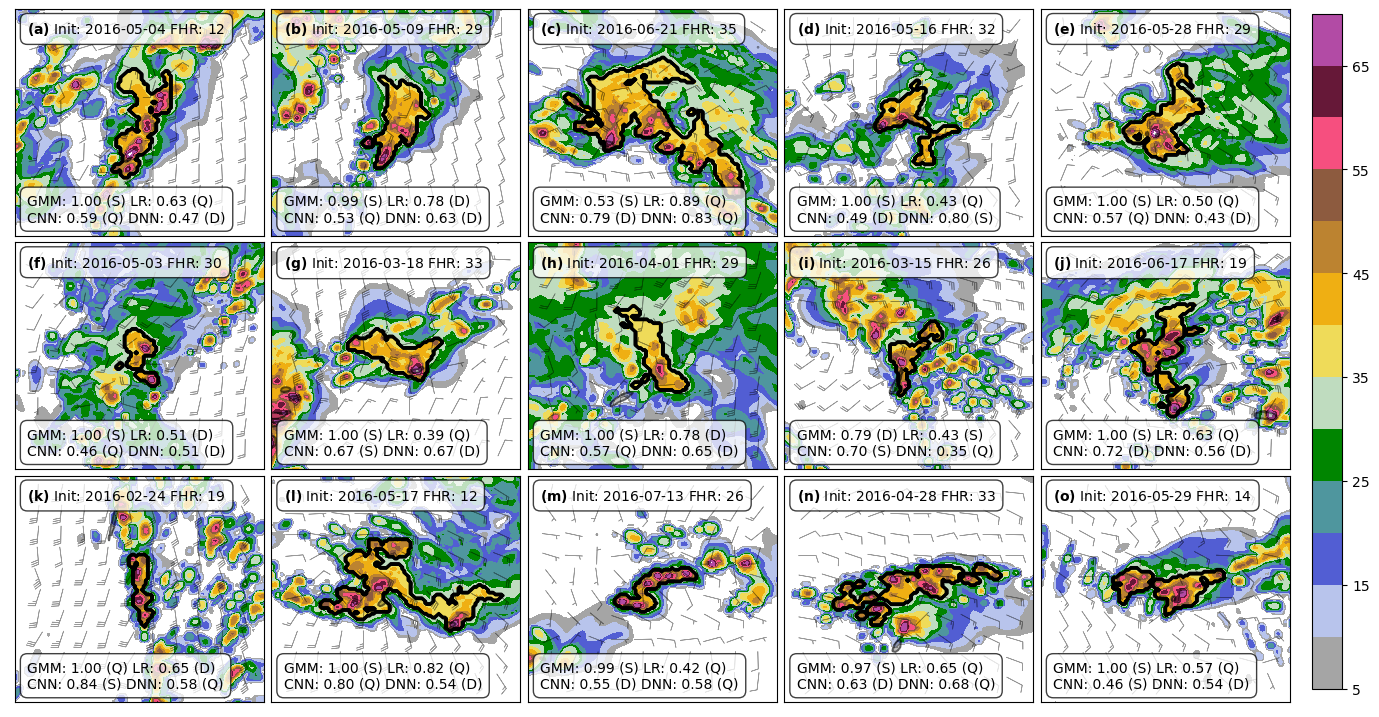

In [6]:
num_cols = 5
fig, axes = plt.subplots(3, num_cols, figsize=(15,9), constrained_layout=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# SS_label field shows cluster label??
categories = { 0: 'QLCS', 1: 'Supercell', 2: 'Disorganized' }
labels['SS_label'] = np.argmax( labels[['SS_QLCS_prob','SS_Supercell_prob','SS_Disorganized_prob']].values , axis=1)
labels['SS_label'] = labels['SS_label'].apply(lambda x: categories[x])

# number of unique classifications among 4 classifiers
labels['unique_labels'] = labels[['SS_label', 'LR_label', 'CNN_1_label', 'DNN_1_label']].apply(pd.Series.nunique, axis=1)
labels_var_sorted = labels.sort_values(by=[f'unique_labels'], ascending=False)

inits_used = []
num_storms_plotted = 0

for k in range(30):
    this_init = labels_var_sorted.iloc[k][[f'Run_Date']].values
    if this_init in inits_used: continue
    num_storms_plotted += 1
    inits_used.append(this_init)

    row = int( (num_storms_plotted-1) /num_cols)
    col = (num_storms_plotted-1)%num_cols
    this_axis = axes[row,col]

    print('storm %d'%num_storms_plotted)
    #print(labels_var_sorted.iloc[k][[f'Run_Date', 'Forecast_Hour', f'SS_label', f'LR_label', f'CNN_1_label', f'DNN_1_label', 'UP_HELI_MAX_max']])
   # print(labels_var_sorted.iloc[k][[ f'CNN_1_Disorganized_prob']])

    this_init, this_lat, this_lon, this_fhr = labels_var_sorted.iloc[k][['Run_Date', 'Centroid_Lat', 'Centroid_Lon', 'Forecast_Hour']].values

    yyyymmdd = this_init.strftime('%Y%m%d')
    ds = xr.open_dataset(join(data_path, f'NCARSTORM_{yyyymmdd}-0000_d01_model_patches.nc'))

    # have to read in CSV to get index number
    df_csv = pd.read_csv(f'/glade/work/cbecker/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_{yyyymmdd}-0000.csv')
    mask = ( (df_csv['Centroid_Lat'] == this_lat) & (df_csv['Centroid_Lon'] == this_lon) & (df_csv['Forecast_Hour'] == this_fhr) )
    this_idx = df_csv[mask].index.values[0]
    if mask.sum() > 1: print('more than one match...')

    patch_center = int(ds.row.size / 2)
    refl_var = [v for v in ds.data_vars if "REFL" in v][0]
    x = ds[[refl_var, 'U10_curr', 'V10_curr', 'masks', 'UP_HELI_MAX_curr']].isel(p=this_idx, row=slice(patch_center - patch_radius, patch_center + patch_radius),
                                                                   col=slice(patch_center - patch_radius, patch_center + patch_radius)).load()
    wind_step = int(np.ceil(np.sqrt(x.row.size)))
    wind_slice = (slice(wind_step, None, wind_step), slice(wind_step, None, wind_step))
    x_mesh, y_mesh = np.meshgrid(range(len(x['row'])), range(len(x['col'])))

    im = this_axis.contourf(x['REFL_COM_curr'], levels=levels, cmap=cmap, norm=norm)

    this_axis.contour(x['masks'], colors='k')

    if x['UP_HELI_MAX_curr'].max() > 75:
        this_axis.contour(x['UP_HELI_MAX_curr'], levels=[75, 500], vmin=75, colors='k', alpha=0.5)
        this_axis.contourf(x['UP_HELI_MAX_curr'], levels=[75, 500], vmin=75, colors='k', alpha=0.25)

    this_axis.barbs(x_mesh[wind_slice], y_mesh[wind_slice], x['U10_curr'][wind_slice] * ms_mph, x['V10_curr'][wind_slice] * ms_mph, color='k', alpha=0.4, linewidth=0.5, pivot='middle', length=5, sizes={'emptybarb':0.05})

    props = dict(boxstyle='round', facecolor='white', alpha=0.75, pad=0.5)
    
    probs = labels_var_sorted.iloc[k][['SS_label_prob', 'LR_label_prob', 'CNN_1_label_prob', 'DNN_1_label_prob']].values
    modes = labels_var_sorted.iloc[k][['SS_label', 'LR_label', 'CNN_1_label', 'DNN_1_label']].values.astype('<U1')
    
    text = f'GMM: %.2f ({modes[0]})'%(probs[0]) + f' LR: %.2f ({modes[1]})'%(probs[1]) + "\n"\
           f'CNN: %.2f ({modes[2]})'%(probs[2]) + f' DNN: %.2f ({modes[3]})'%(probs[3])
    
    this_axis.text(0.05, 0.05, text, transform=this_axis.transAxes, fontsize=10, va='bottom', ha='left', bbox=props)
    
    text = r"$\bf{ (" + panels[num_storms_plotted-1] + ")}$ Init: %s FHR: %d"%(labels_var_sorted['Run_Date'].iloc[k].strftime("%Y-%m-%d"), labels_var_sorted['Forecast_Hour'].iloc[k])
    this_axis.text(0.05, 0.95, text, transform=this_axis.transAxes, fontsize=10, va='top', ha='left', bbox=props)

    #axes[0].text(6, 11, f"P = {str(np.round(sub.iloc[i, :]['SS_label_prob'], 2))}", style='italic', fontsize=10, bbox={'facecolor': 'lightgrey', 'alpha': 0.8, 'pad': 4})

    plt.subplots_adjust(right=0.975)
    this_axis.set_xticks([])
    this_axis.set_xticks([], minor=True)
    this_axis.set_yticks([])
    this_axis.set_yticks([], minor=True)

    if num_storms_plotted == 15: break
    
cbar_ax = fig.add_axes([0.99, 0.125, 0.02, 0.75])
fig.colorbar(im, cbar_ax)

#plt.savefig('examples_disagree_mode.png', bbox_inches='tight')